# Introduction to Solar System Dynamics

In the previous exercise we learned how to calculate high-precision ephemerides for solar system objects, suitable for making very accurate observations over periods of minutes or hours. Now we turn to the behavior of solar system objects over much longer times, ranging from hundreds of years to the age of the solar system. We'll learn how to calculate the mutual gravitational interactions between the planets, and see how these influence the long-term evolution of their own orbits and those of the asteroids. 

The equations of motion for the solar system are given by writing down Newton's law of gravitation for the $N$-body system:

$$
    m\frac{d^2\vec{\mathbf{r}}_i}{dt^2} = -Gm_i\sum_{j\ne i}\frac{m_j}{\left|\vec{\mathbf{r}}_j - \vec{\mathbf{r}}_i\right|^3}(\vec{\mathbf{r}}_j - \vec{\mathbf{r}}_i).
$$
This is a system of $3N$ coupled, nonlinear equations that cannot be solved exactly for $N>2$. So we integrate the equations numerically. Starting with some initial state, we use the equations of motion to compute the changes in velocity and position over some time step $\Delta t$, then recompute the forces, and so on. Many techniques have been developed to minimize the accumulation of errors, and modern numerical routines are extremely accurate.


# Describing an Orbit

Any discussion of solar system dynamics needs to begin with a language for describing an orbit. In an idealized 2-body system consisting of a central body (e.g. the sun) and one planet, the planet will follow an orbit described by [Kepler's laws](https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion):
* The orbit is an ellipse, with one focus at the center of mass of the system.
* A line connecting the center of mass to the planet sweeps out equal areas in equal times.
* The square of the period is proportional to the cube of the semi-major axis.

In these idealized conditions, we can describe an orbit with 6 parameters, known as the <b>Keplerian elements</b>:

![picture](https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Orbit1.svg/580px-Orbit1.svg.png)

These parameters are:
* Two parameters that describe the size and shape of the orbit: the semi-major axis ($a$) and the eccentricity ($e$). $a$ is usually measured in astronomical units (AU) where 1 AU is the mean distance from the earth to the sun, about 150 million km. Eccentricity is a dimensionless number that is zero for a circlular orbit, 1 for a parabola, and >1 for hyperbolic orbits.
* Three angles that describe the orientation of the orbit in space (analogous to roll, pitch, and yaw): 
 - Inclination ($i$) with respect to a reference plane, typically the ecliptic (the plane of earth's orbit)
 - Longitude of ascending node ($\Omega$), where the orbit intersects the ecliptic
 - Argument of perihelion ($\omega$), the angle between the ascending node and the point where the object reaches perihelion.
* A sixth parameter that describes where the object is located in its orbit. This can be specified in several equivalent ways:
 - Time of perihelion
 - True anomaly ($\nu$), the angle from perihelion to the object's current position.
 - Mean anomaly ($M$), the angle fron perihelion to the object if the object were in a circular orbit with the same semimajor axis. Of course the object doesn't really do this (unless the orbit is actually circular), but it's a convenient angle because it advances at a uniform rate. It can be converted to the true anomaly through a set of steps usually done in software.
 - Finally, there is a seventh, supplementary parameter called the `epoch`, namely the reference time at which these elements are defined. 

 Although the Keplerian elements are the most intuitive and frequently-used way of describing an orbit, there are several other equivalent schemes in use. The most common alternative is the <b>Cartesian elements</b>, which are simply the object's position and velocity at some instant:
 - $x, y, z$ 
 - $v_x, v_y, v_z$
 - $t_0$

Cartesian elemeents are the most useful for initializing a simulation, so most dynamical software includes built-in tools for converting between Keplerian and Cartesian elements. 

In a two-body system, an orbit stays the same forever. This is a consequence of energy and angular momentum conservation. But when we add more objects, their mutual interactions lead to the exchange of energy and momentum, resulting in orbital elements that change with time, sometimes in surprising ways.

---
# Assembling the solar system, one planet at a time

To carry out $N$-body integrations, we will use the python package [`spacerocks`](https://github.com/kjnapier/spacerocks), written by UM Ph.D. student Kevin Napier. It makes use of the [`rebound`](https://rebound.readthedocs.io/en/latest/) N-body integrator, with added functionality to greatly simplify many solar system calculations. It's incredibly powerful and can be used both for long-term integrations like we'll do here, and high-precision ephemerides calculations as an alternative to Horizons.

We'll use `spacerocks` to build up our solar system one giant planet at a time, and see how complexity emerges as the number of interactions increases.

---



In [1]:

from spacerocks.spacerock import SpaceRock
from spacerocks.simulation import Simulation
from spacerocks.model import PerturberModel, builtin_models
from spacerocks.units import Units

import numpy as np
from astropy import units as u
from astropy.time import Time

import matplotlib.pyplot as plt
%matplotlib inline

### Setting up the units

Units, especially for times and angles, can be an abundant source of bugs and confusion. Most modern astronomical software packages, such as `astropy`, have special classes to keep track of dimensionful quantities and facilitiate conversions. `Spacerocks` has its own `Units()` class to help keep things straight.

Of particular note, times in these calculations are measured in the [Barycentric Dynamical Time](https://en.wikipedia.org/wiki/Barycentric_Dynamical_Time) (tbd) timescale -- roughly speaking, the frame in which a clock co-moving with the solar system center-of-mass (barycenter) will tick at a uniform rate.  

In [2]:
units = Units()
units.timescale = 'tdb' 
units.mass = u.M_sun

### Integrating the Sun and Jupiter

We'll begin with a simple two-body system: the Sun and Jupiter. Of course, you don't need a computer to solve this problem, but this is a good starting point for more complicated systems. 

The basic idea is to define the bodies in the problem through a `PerturberModel`. JPL's `spice` package contains descriptions of all major bodies in the solar system, so we use `spice` to create our model. Then we use them to initialize a `Simulation`, which tells it the masses, positions, and velocities of each body at an initial epoch of our choice.

Finally, we `propagate` our simulation through some desired time interval, using an $N$-body integrator. We'll use `rebound`'s `mercurius` integrator.

Two of the most important parameters in any integration are the duration of the integration, and the timestep. The timestep should be a small fraction of the shortest dynamical timescale in the problem. In this case we'll use 50 days, which is about 1% of Jupiter's orbital period. We'll start with a 10,000-year integration.

Output()

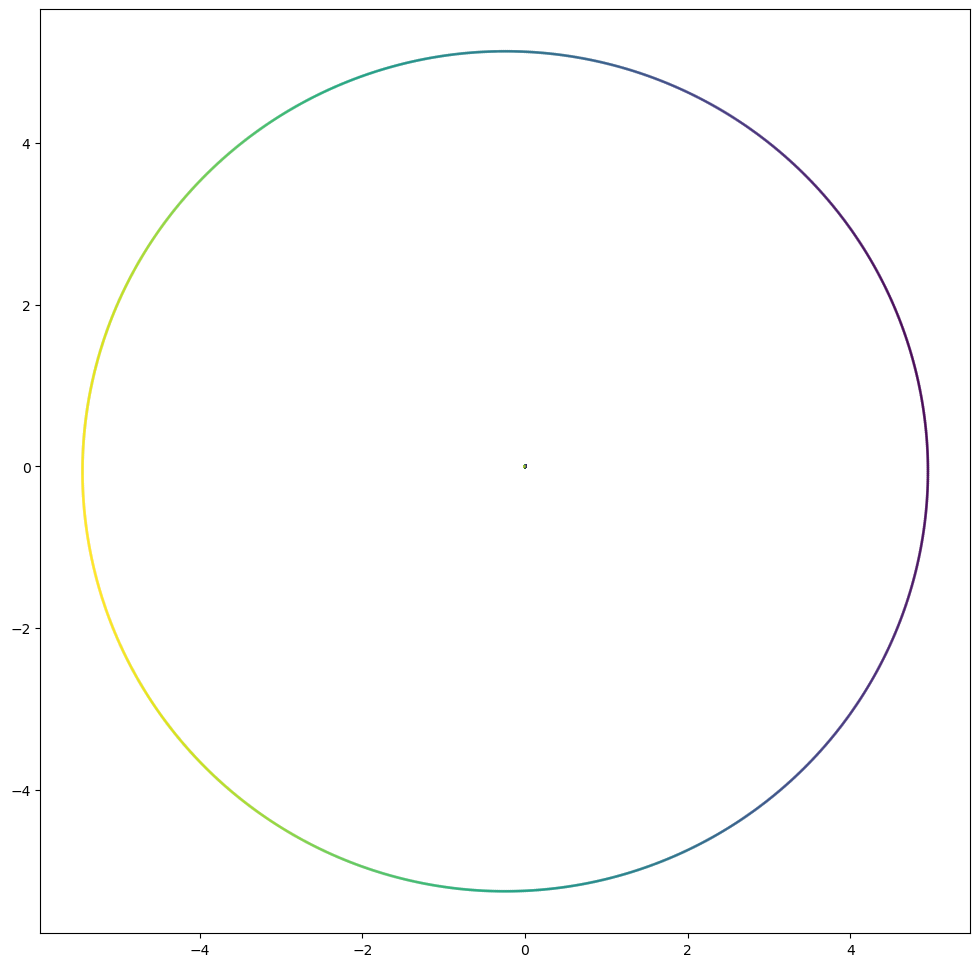

In [3]:
# Start with just the sun and Jupiter
spiceids, kernel, _ = builtin_models['SUN']
spiceids += ['Jupiter Barycenter']

model = PerturberModel(spiceids=spiceids)
sim = Simulation(model=model, epoch=Time('2023-01-01', scale='utc', format='iso'), units=units)

sim.integrator = 'mercurius'
sim.dt = 50

t0 = sim.epoch.tdb.jd
tf = t0 + 10000 * 365.25
epochs = np.arange(t0, tf, 200) # Save the state of the simulation every 200 days

prop, planets, _ = sim.propagate(epochs=epochs, units=units, exact_finish_time=0)

fig, ax = plt.subplots(figsize=(12, 12))
for name, planet in planets.groupby('name'):
  ax.scatter(planet.x.au, planet.y.au, c=planet.z.au, cmap='viridis', s=1, alpha=0.1)


The result is not particularly surprising! Jupiter makes the same slightly elliptical orbit around the sun. We can also examine some of Jupiter's orbital elements, namely its eccentricity axis and its inclination. As you can see below, these are completely stable.

Text(0.5, 0, 't')

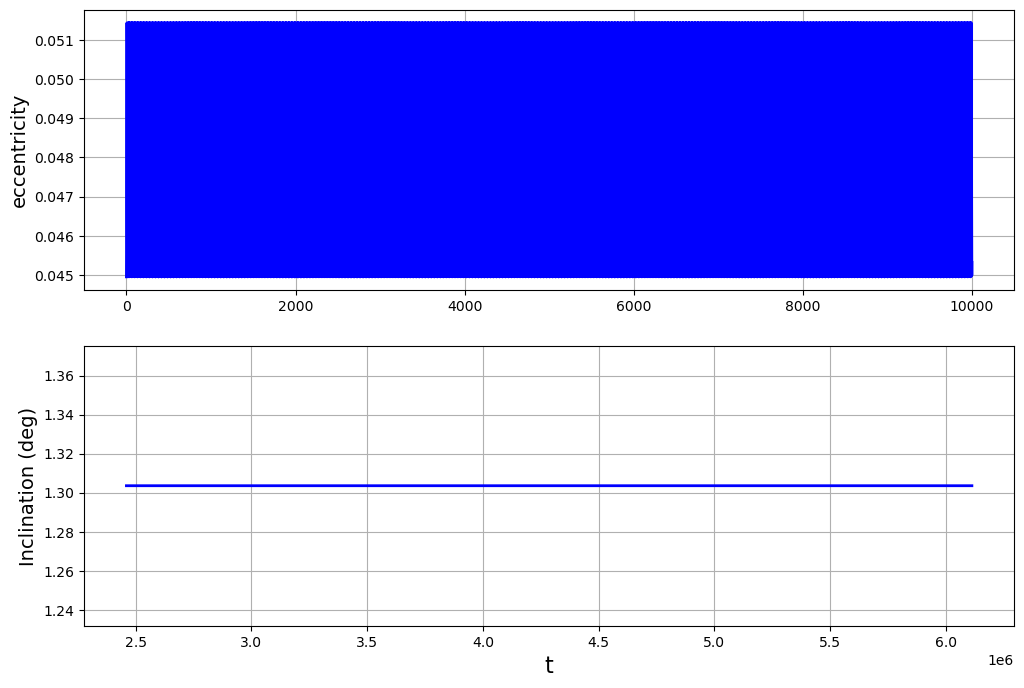

In [4]:
jup = planets[planets.name=="Jupiter Barycenter"]
years = (epochs - t0)/365.25
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(years, jup.e, lw=2, color='b')
ax1.grid()
ax1.set_ylabel('eccentricity', fontsize=14)
ax2.plot(epochs, jup.inc.deg, lw=2, color='b')
ax2.grid()
ax2.set_ylabel('Inclination (deg)', fontsize=14)
ax2.set_xlabel('t', fontsize=16)

### Adding Saturn to the picture

Next we'll repeat the above steps, but add Saturn. We'll also extend our integration to 100,000 years.

Output()

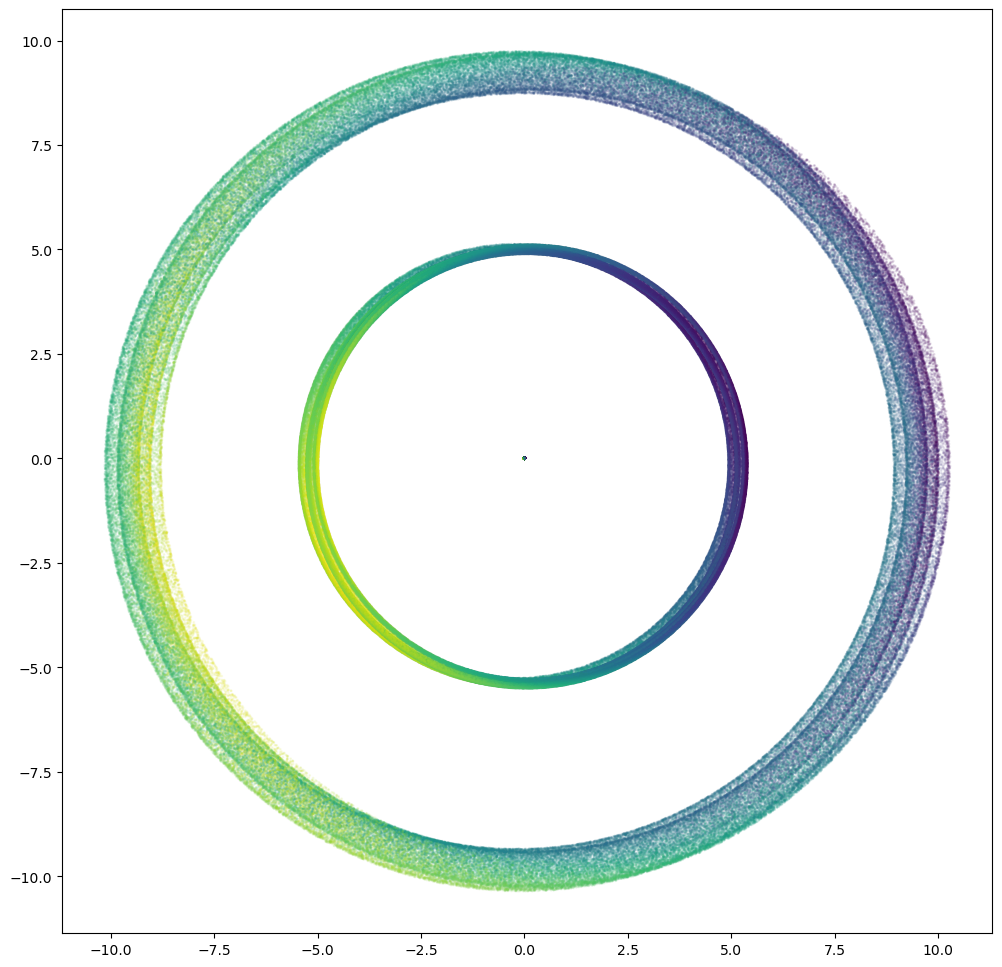

In [6]:
spiceids += ['Saturn Barycenter']
model = PerturberModel(spiceids=spiceids)
sim = Simulation(model=model,  epoch=Time('2023-01-01', scale='utc', format='iso'), units=units)

t0 = sim.epoch.tdb.jd
tf = t0 + 100000 * 365.25
epochs = np.arange(t0, tf, 200)

prop, planets, sim = sim.propagate(epochs=epochs, units=units, exact_finish_time=0)

fig, ax = plt.subplots(figsize=(12, 12))
for name, planet in planets.groupby('name'):
    ax.scatter(planet.x.au, planet.y.au, c=planet.z.au, cmap='viridis', s=1, alpha=0.1)

This is a much more interesting picture! Jupiter's and Saturn's orbits "wobble" due their mutual interactions. In fact we can see that they vary synchronously, on a timescale of about 50,000 years. Moreover the eccentricity and inclination oscillations are about 90 degrees out of phase.

Text(0.5, 0, 't')

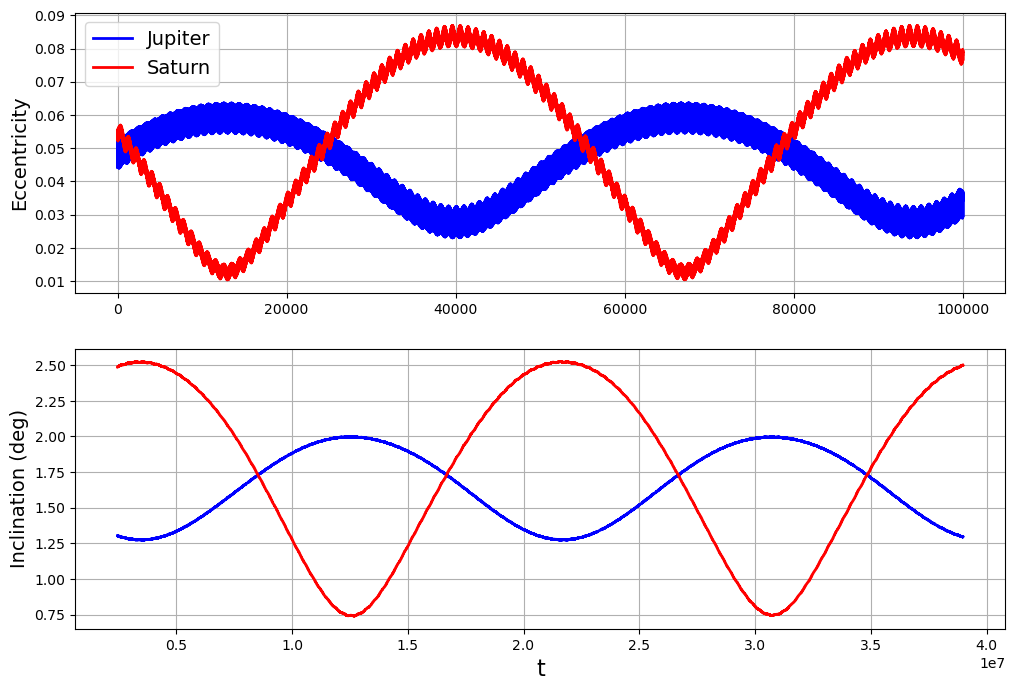

In [7]:
jup = planets[planets.name=="Jupiter Barycenter"]
sat = planets[planets.name=="Saturn Barycenter"]
years = (epochs - t0)/365.25
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(years, jup.e, lw=2, color='b', label="Jupiter")
ax1.plot(years, sat.e, lw=2, color='r', label="Saturn")
ax1.legend(fontsize=14)
ax1.grid()
ax1.set_ylabel('Eccentricity', fontsize=14)
#ax.set_ylim([5.15, 5.2]))
ax2.plot(epochs, jup.inc.deg, lw=2, color='b', label="Jupiter")
ax2.plot(epochs, sat.inc.deg, lw=2, color='r', label="Saturn")
ax2.grid()
ax2.set_ylabel('Inclination (deg)', fontsize=14)
ax2.set_xlabel('t', fontsize=16)

### Adding Uranus

We keep going... now we extend the integration to 100,000 years, and save the results every 10 years

Output()

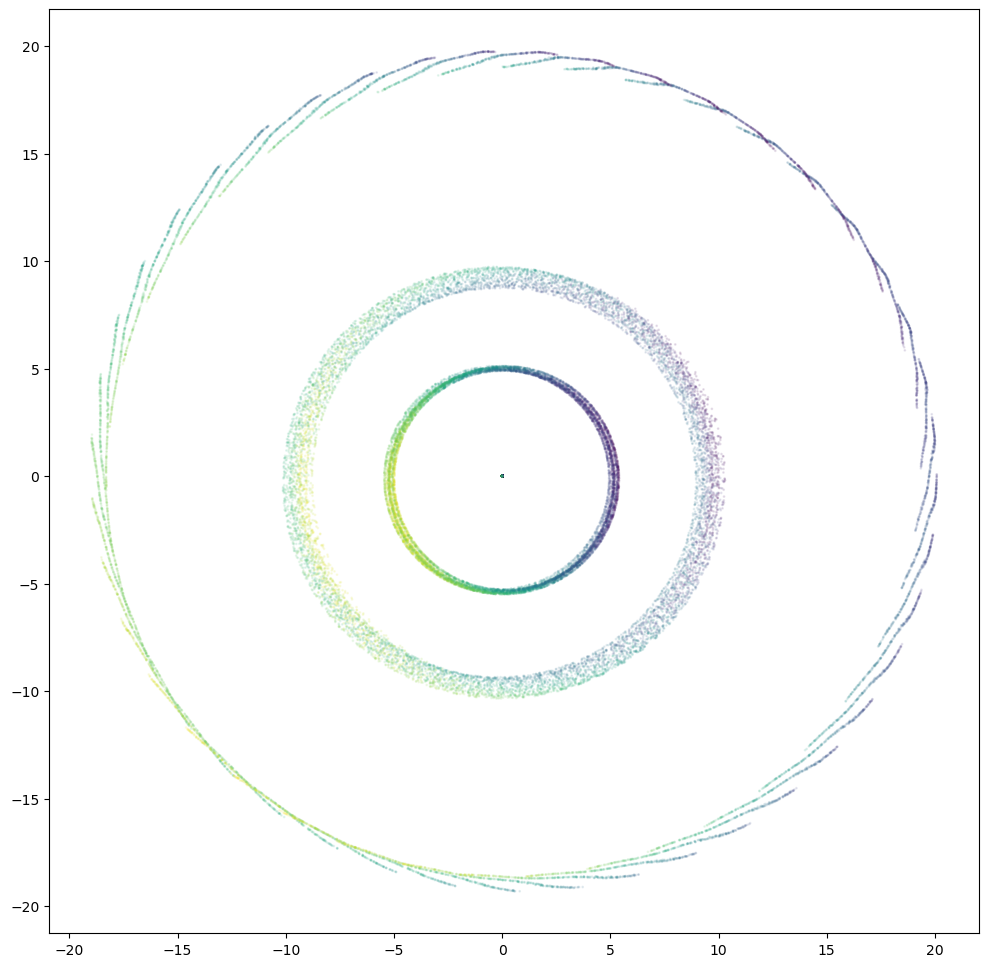

In [8]:
spiceids += ['Uranus Barycenter']
model = PerturberModel(spiceids=spiceids)
sim = Simulation(model=model,  epoch=Time('2023-01-01', scale='utc', format='iso'), units=units)

t0 = sim.epoch.tdb.jd
tf = t0 + 100_000 * 365.25
epochs = np.arange(t0, tf, 365.25*10)

prop, planets, sim = sim.propagate(epochs=epochs, units=units, exact_finish_time=0)

fig, ax = plt.subplots(figsize=(12, 12))
for name, planet in planets.groupby('name'):
    ax.scatter(planet.x.au, planet.y.au, c=planet.z.au, cmap='viridis', s=1, alpha=0.1)

Text(0.5, 0, 't')

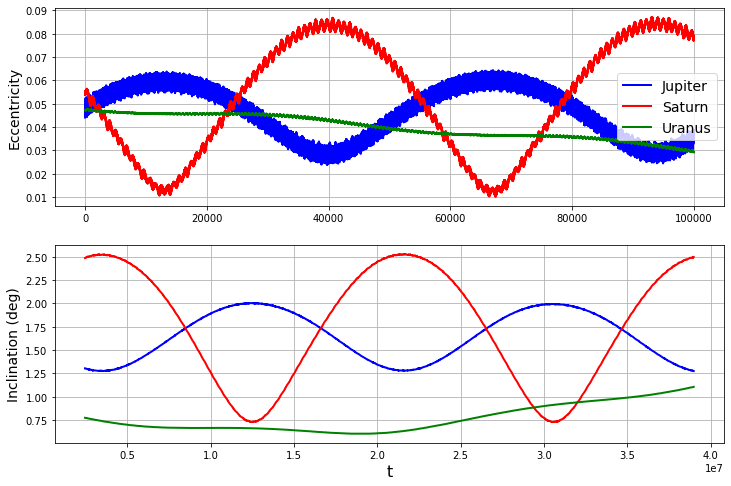

In [ ]:
jup = planets[planets.name=="Jupiter Barycenter"]
sat = planets[planets.name=="Saturn Barycenter"]
ura = planets[planets.name=="Uranus Barycenter"]
years = (epochs - t0)/365.25
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(years, jup.e, lw=2, color='b', label="Jupiter")
ax1.plot(years, sat.e, lw=2, color='r', label="Saturn")
ax1.plot(years, ura.e, lw=2, color='g', label="Uranus")
ax1.legend(fontsize=14)
ax1.grid()
ax1.set_ylabel('Eccentricity', fontsize=14)
ax2.plot(epochs, jup.inc.deg, lw=2, color='b', label="Jupiter")
ax2.plot(epochs, sat.inc.deg, lw=2, color='r', label="Saturn")
ax2.plot(epochs, ura.inc.deg, lw=2, color='g', label="Uranus")
ax2.grid()
ax2.set_ylabel('Inclination (deg)', fontsize=14)
ax2.set_xlabel('t', fontsize=16)

### And finally, Neptune

For this step, we increase the integration time to 1 million years, and save things every 100 years. You can see a rich array of behavior happening on a variety of timescales. 

Output()

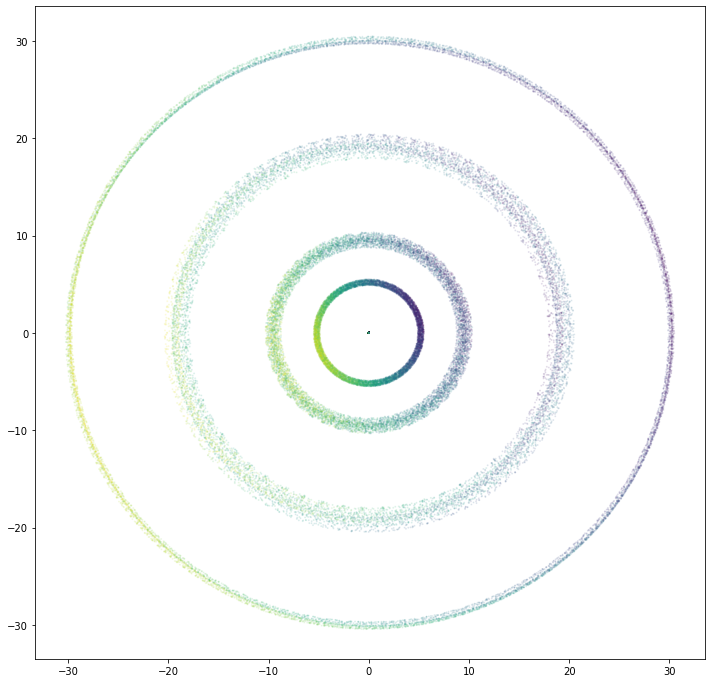

In [ ]:
spiceids, kernel, _ = builtin_models['GIANTS']
model = PerturberModel(spiceids=spiceids)
sim = Simulation(model=model, epoch=Time('2023-01-01', scale='utc', format='iso'), units=units)
sim.dt = 50
t0 = sim.epoch.tdb.jd
tf = t0 + 1_000_000 * 365.25
epochs = np.arange(t0, tf, 365.25*100)

prop, planets, sim = sim.propagate(epochs=epochs, units=units, exact_finish_time=0)

fig, ax = plt.subplots(figsize=(12, 12))
for name, planet in planets.groupby('name'):
    ax.scatter(planet.x.au, planet.y.au, c=planet.z.au, cmap='viridis', s=1, alpha=0.1)

Text(0.5, 0, 't (Myr)')

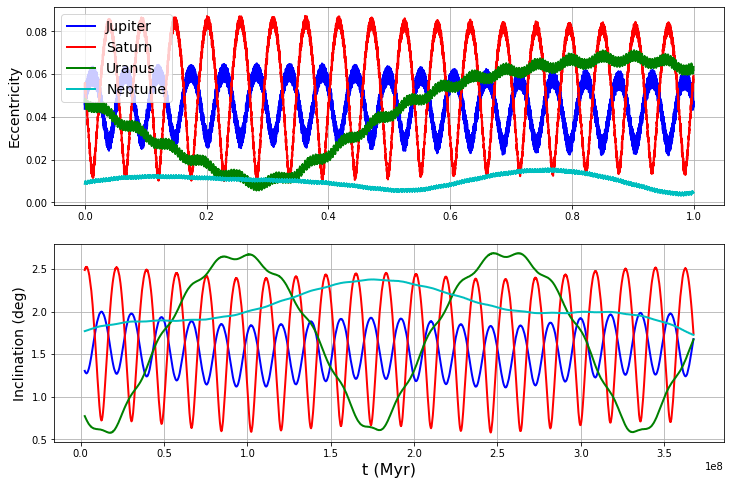

In [ ]:
jup = planets[planets.name=="Jupiter Barycenter"]
sat = planets[planets.name=="Saturn Barycenter"]
ura = planets[planets.name=="Uranus Barycenter"]
nep = planets[planets.name=="Neptune Barycenter"]
years = (epochs - t0)/365.25/1_000_000
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
ax1.plot(years, jup.e, lw=2, color='b', label="Jupiter")
ax1.plot(years, sat.e, lw=2, color='r', label="Saturn")
ax1.plot(years, ura.e, lw=2, color='g', label="Uranus")
ax1.plot(years, nep.e, lw=2, color='c', label="Neptune")
ax1.legend(fontsize=14)
ax1.grid()
ax1.set_ylabel('Eccentricity', fontsize=14)
ax2.plot(epochs, jup.inc.deg, lw=2, color='b', label="Jupiter")
ax2.plot(epochs, sat.inc.deg, lw=2, color='r', label="Saturn")
ax2.plot(epochs, ura.inc.deg, lw=2, color='g', label="Uranus")
ax2.plot(epochs, nep.inc.deg, lw=2, color='c', label="Neptune")
ax2.grid()
ax2.set_ylabel('Inclination (deg)', fontsize=14)
ax2.set_xlabel('t (Myr)', fontsize=16)

### And now the full JPL perturber model

This includes the 8 planets (including the Earth and Moon as a resolved system), Pluto, and the 16 largest asteroids, all as one big mutually-gravitating system.

For this step we switch to the `whfast` integrator, which is faster than `mercurius` and nearly as accurate. We also change the timestep to 2 days, for compatibility with Mercury's 88-day period. We reduce the period of integration to 10,000 years, and evaluate the state of the system every 200 days.

In [ ]:
spiceids, kernel, _ = builtin_models['HORIZONS']
model = PerturberModel(spiceids=spiceids, kernel=kernel)
sim = Simulation(model=model,  epoch=Time('2023-01-01', scale='utc', format='iso'), units=units)
sim.dt = 2
sim.integrator = 'whfast'

t0 = sim.epoch.tdb.jd
tf = t0 + 10_000 * 365.25
epochs = np.arange(t0, tf, 200)

prop, planets, _ = sim.propagate(epochs=epochs, units=units, exact_finish_time=0)

Output()

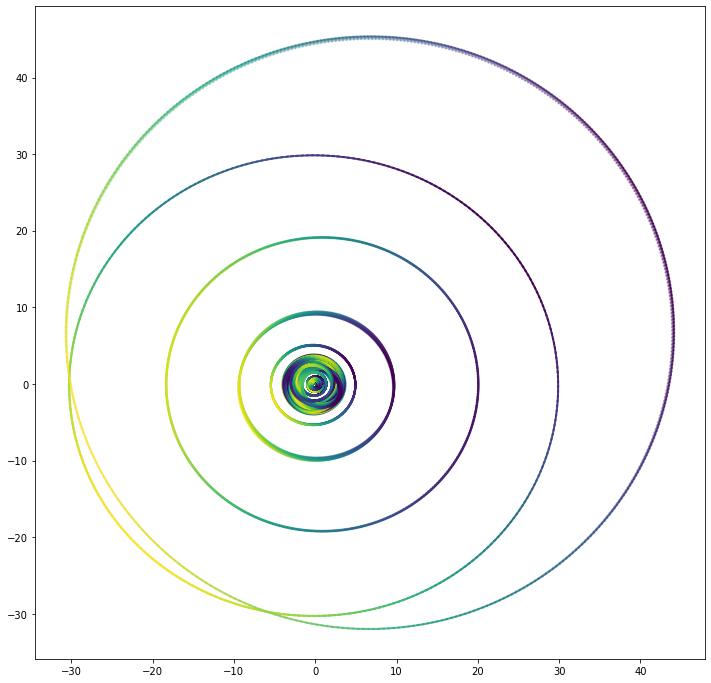

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
for name, planet in planets.groupby('name'):
    ax.scatter(planet.x.au, planet.y.au, c=planet.z.au, cmap='viridis', s=1, alpha=0.1)

---

(-4.0, 4.0)

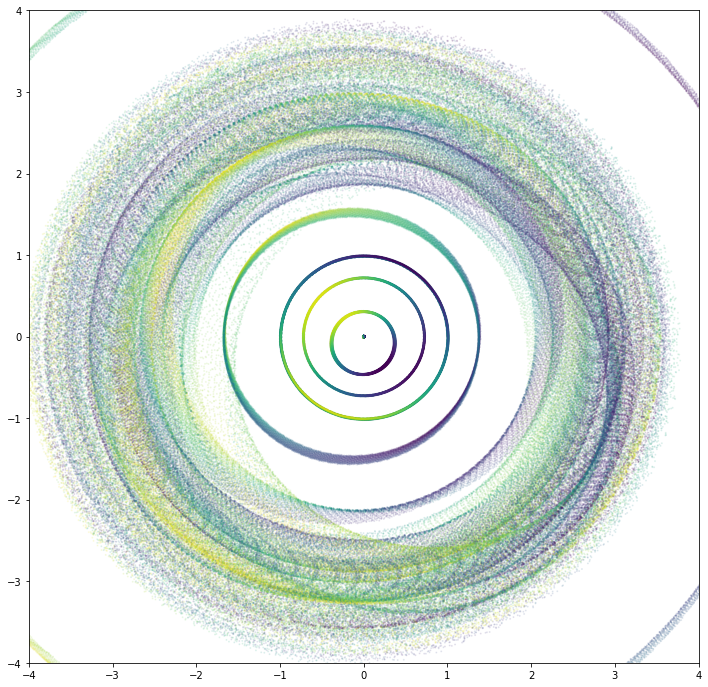

In [ ]:
# Zoom in on the inner solar system. You can see Mercury, Venus, Earth, Mars, and the asteroids. 
fig, ax = plt.subplots(figsize=(12, 12))
for name, planet in planets.groupby('name'):
    ax.scatter(planet.x.au, planet.y.au, c=planet.z.au, cmap='viridis', s=1, alpha=0.1)
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])

# Homework (Due Friday, 2/10)
* Investigate the stability of Earth's orbit over 1 million years, within the context of the full Horizons model. You'll need to choose your integration parameters carefully to avoid taking a prohibitively long time. I suggest using a 2-day timestep with the `whfast` integrator, and saving results every 200 years. 
 - Over what range does earth's semi-major axis, eccentricity, and inclination vary? 
 - Could variations in earth's orbit be an explanation for long-term climate change? 

* You can see in the second-to-last figure above that Pluto crosses Neptune's orbit. Will they ever have a collision?
 - Using the same integration as you did above (you shouldn't have to repeat it), make a plot of the separation between Pluto and Neptune vs. time. 
 - What is the ratio of Pluto's orbital period to that of Neptune? How might this explain your result above? 

 Hints:
* With the integration parameters above, your 1 Myr integration will take around 40 minutes on the Colab server. So you should test your code over a shorter period of time before moving on to the longer integration. 
* To get a specific object from the `planets` variable generated by the simulation, slice that variable by name, e.g.

`earth = planets[planets.name=='Earth']` # Not 'Earth Barycenter' since the earth and moon are resolved as separate bodies!

`neptune = planets[planets.name=='Neptune Barycenter']`

`pluto = planets[planets.name == 'Pluto Barycenter']`

The example plots above should illustrate how to access the objects' positions and orbital elements at each epoch.